<a href="https://colab.research.google.com/github/amardeep786/Regressors/blob/main/RegressorDetect1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-2688f54bb77e>:26: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/sample_data/updated_file_Detect.csv')


Data Loaded. Head of the DataFrame:
  Image No Image Pixel  Processing Time  Iteration Combination Current Script  \
0      1.0     448x640             40.6          1           d      detect.py   
1      2.0     640x608             42.6          1           d      detect.py   
2      3.0     512x640             41.3          1           d      detect.py   
3      4.0     640x480             40.6          1           d      detect.py   
4      5.0     640x448             40.0          1           d      detect.py   

   Execution Time (seconds)  RAM Memory Usage (MB)  \
0                 15.246717            1350.964844   
1                 15.246717            1350.964844   
2                 15.246717            1350.964844   
3                 15.246717            1350.964844   
4                 15.246717            1350.964844   

                                  CPU Usage Per Core  GPU Usage (%)  ...  \
0  [0.0, 0.0, 0.0, 0.0, 9.1, 0.0, 0.0, 0.0, 0.0, ...             35  ...   


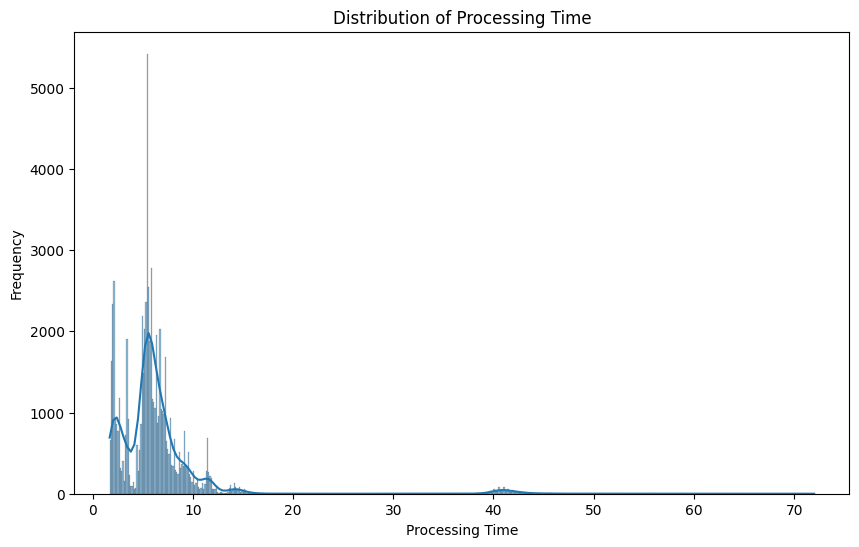

Distribution Counts:
Processing Time
1.7       13
1.8      654
1.9     1634
2.0     2338
2.1     1613
        ... 
63.0       1
63.3       1
66.6       1
66.8       1
72.0       1
Name: count, Length: 329, dtype: int64


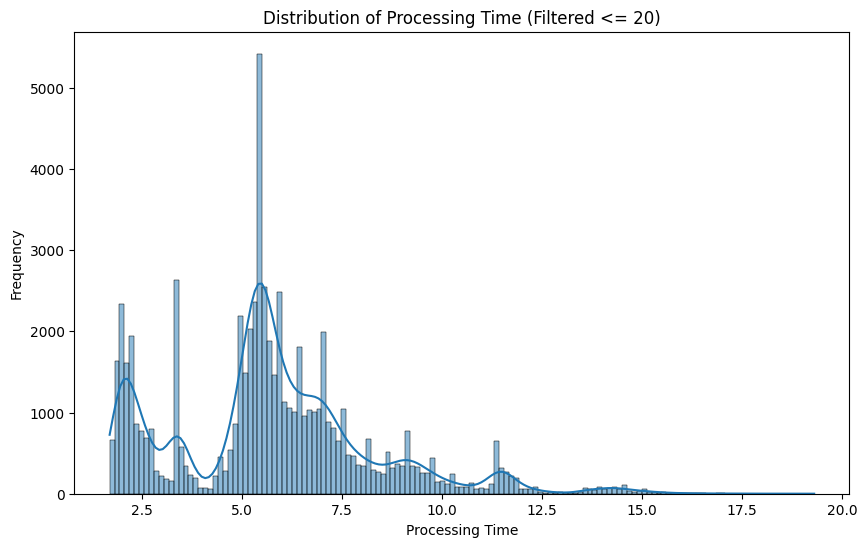

Distribution Counts after filtering:
Processing Time
1.7       13
1.8      654
1.9     1634
2.0     2338
2.1     1613
        ... 
18.6       2
18.7       1
18.8       1
19.0       1
19.3       1
Name: count, Length: 165, dtype: int64

Features (X) head:
   Image Pixel Combination Current Script  RAM Memory Usage (MB)  \
5      448x640           d      detect.py            1350.964844   
6      640x448           d      detect.py            1350.964844   
7      640x480           d      detect.py            1350.964844   
8      512x640           d      detect.py            1350.964844   
11     480x640           d      detect.py            1350.964844   

                                   CPU Usage Per Core  GPU Usage (%)  \
5   [0.0, 0.0, 0.0, 0.0, 9.1, 0.0, 0.0, 0.0, 0.0, ...             35   
6   [0.0, 0.0, 0.0, 0.0, 9.1, 0.0, 0.0, 0.0, 0.0, ...             35   
7   [0.0, 0.0, 0.0, 0.0, 9.1, 0.0, 0.0, 0.0, 0.0, ...             35   
8   [0.0, 0.0, 0.0, 0.0, 9.1, 0.0, 0.0, 0.0, 0.0

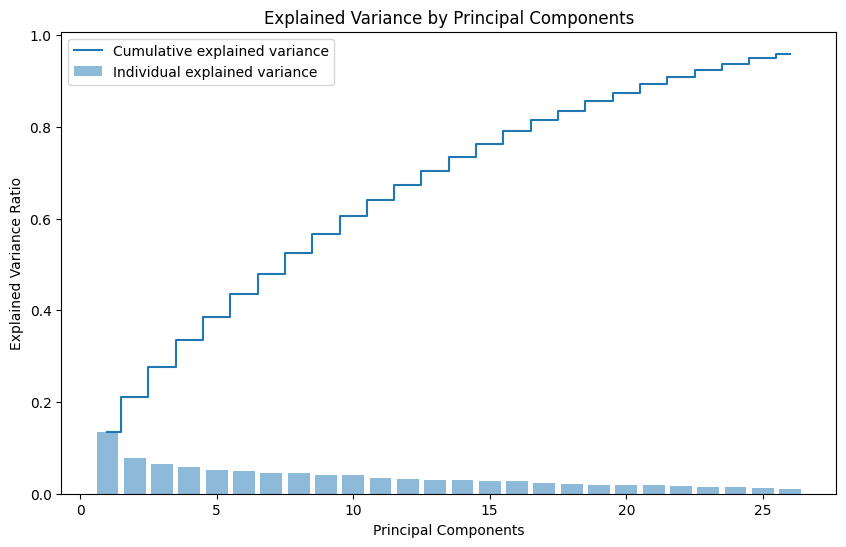


Train-Test Split:
Training Samples: 53034
Testing Samples: 13259

Starting Grid Search for Hyperparameter Tuning...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Grid Search Complete.
Best Parameters: {'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 100)}
Best Score (MSE): 2.7618

Evaluation on Test Set using the Best Model:
Mean Squared Error (MSE): 2.6060
R² Score: 0.5971


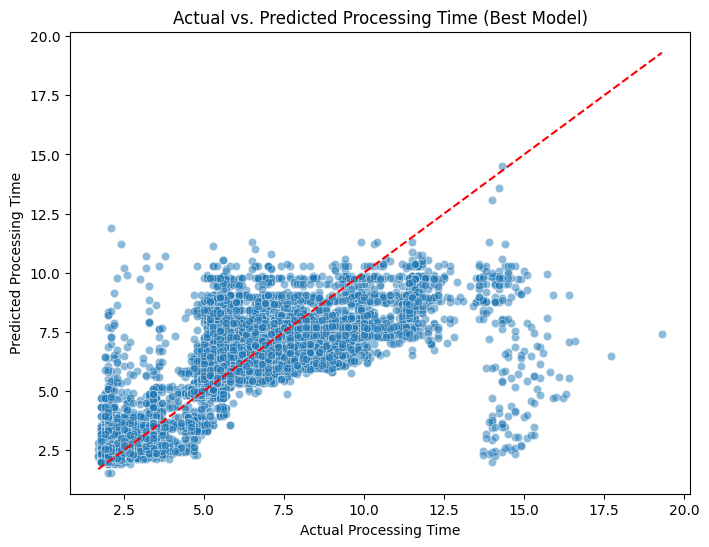

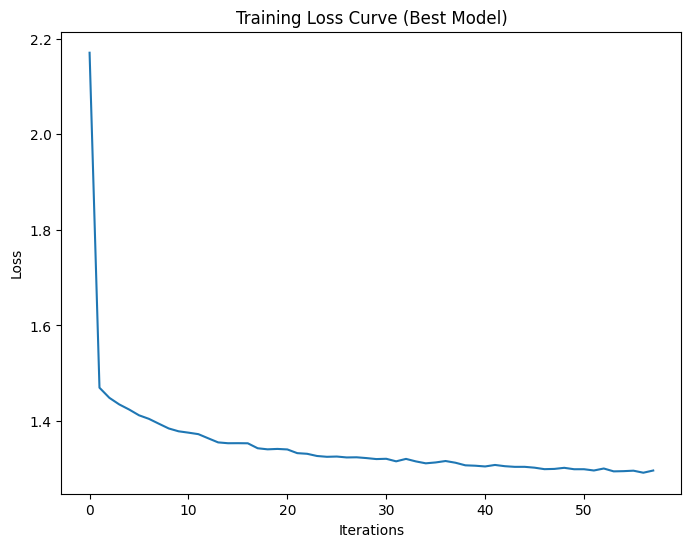

In [1]:
# -*- coding: utf-8 -*-
"""
RegressorDetect_with_HyperparamTuning.ipynb

Example script that demonstrates hyperparameter tuning with MLPRegressor.
"""

import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# --------------------------------------------------------------------------------------
# 1. Load Data
# --------------------------------------------------------------------------------------
df = pd.read_csv('/content/sample_data/updated_file_Detect.csv')
print("Data Loaded. Head of the DataFrame:")
print(df.head())

# --------------------------------------------------------------------------------------
# 2. Basic EDA and filtering
# --------------------------------------------------------------------------------------
print("\nDataFrame Columns:")
print(df.columns)

# Plot the distribution of Processing Time
plt.figure(figsize=(10, 6))
sns.histplot(df['Processing Time'], kde=True)
plt.title('Distribution of Processing Time')
plt.xlabel('Processing Time')
plt.ylabel('Frequency')
plt.show()

# Print distribution counts
distribution_counts = df['Processing Time'].value_counts().sort_index()
print("Distribution Counts:")
print(distribution_counts)

# Filter out Processing Time > 20
df = df[df['Processing Time'] <= 20]

# Plot the distribution again after filtering
plt.figure(figsize=(10, 6))
sns.histplot(df['Processing Time'], kde=True)
plt.title('Distribution of Processing Time (Filtered <= 20)')
plt.xlabel('Processing Time')
plt.ylabel('Frequency')
plt.show()

# Print new distribution counts
distribution_counts = df['Processing Time'].value_counts().sort_index()
print("Distribution Counts after filtering:")
print(distribution_counts)

# --------------------------------------------------------------------------------------
# 3. Drop unwanted columns
# --------------------------------------------------------------------------------------
columns_to_drop = [
    'Image No',
    'Iteration',
    'Execution Time (seconds)',
    'File',
    'Duration'
]

df = df.drop(columns=columns_to_drop, errors='ignore')

# --------------------------------------------------------------------------------------
# 4. Separate features (X) and target (y)
# --------------------------------------------------------------------------------------
y = df['Processing Time']
X = df.drop(columns=['Processing Time'])

print("\nFeatures (X) head:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())

# --------------------------------------------------------------------------------------
# 5. Data Cleaning / Feature Engineering
# --------------------------------------------------------------------------------------
print("\nData Types of X:")
print(X.dtypes)

# Split 'Image Pixel' into width and height, then create image_size
X[['width', 'height']] = X['Image Pixel'].str.split('x', expand=True).astype(int)
X['image_size'] = X['width'] * X['height']
X.drop(columns=['Image Pixel'], inplace=True)

# Optionally drop columns if not needed
# (Already stated in your code, removing 'Current Script' and 'Total CPU Cores')
X.drop(columns=['Current Script','Total CPU Cores'], inplace=True, errors='ignore')

# One-hot encoding of categorical columns
categorical_data = ['CPU Model','GPU Model']
encoder = pd.get_dummies(X[categorical_data], drop_first=False)
X = pd.concat([X, encoder], axis=1)
X.drop(columns=categorical_data, inplace=True)

# Count occurrences of p, s, d in 'Combination'
X['num_p'] = X['Combination'].str.count('p')
X['num_s'] = X['Combination'].str.count('s')
X['num_d'] = X['Combination'].str.count('d')
X.drop(columns=['Combination'], inplace=True)

# Convert CPU Usage Per Core from string to list
X['CPU Usage Per Core'] = X['CPU Usage Per Core'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Expand CPU usage into separate columns
cpu_columns = [f'cpu_core_{i+1}' for i in range(32)]
X[cpu_columns] = pd.DataFrame(X['CPU Usage Per Core'].tolist(), columns=cpu_columns, index=X.index)
X.drop(columns=['CPU Usage Per Core'], inplace=True)

print("\nFeature columns after transformations:")
print(X.columns)

# --------------------------------------------------------------------------------------
# 6. Dimensionality Reduction (PCA on CPU usage)
# --------------------------------------------------------------------------------------
scaler = StandardScaler()
X_cpu_scaled = scaler.fit_transform(X[cpu_columns])

pca_optimal = PCA(n_components=0.95, random_state=42)
X_cpu_pca_optimal = pca_optimal.fit_transform(X_cpu_scaled)

print(f"\nNumber of PCA components to retain 95% variance: {pca_optimal.n_components_}")

# Create PCA component names
pca_optimal_columns = [f'cpu_pca_optimal_{i+1}' for i in range(X_cpu_pca_optimal.shape[1])]
cpu_pca_optimal_df = pd.DataFrame(X_cpu_pca_optimal, columns=pca_optimal_columns, index=X.index)

# Concatenate the PCA components with the original DataFrame
X = pd.concat([X, cpu_pca_optimal_df], axis=1)

# Drop the original CPU usage columns
X.drop(cpu_columns, axis=1, inplace=True)

# Optionally visualize PCA variance
explained_variance = pca_optimal.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10,6))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.5,
        align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance)+1), cumulative_variance,
         where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.show()

# --------------------------------------------------------------------------------------
# 7. Final Train-Test Split
# --------------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("\nTrain-Test Split:")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")

# --------------------------------------------------------------------------------------
# 8. Hyperparameter Tuning with GridSearchCV
# --------------------------------------------------------------------------------------
# We'll build a pipeline that first scales data, then applies MLPRegressor
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        activation='relu',
        solver='adam',
        random_state=42,
        max_iter=200,          # Increase if needed
        early_stopping=True,   # Use early stopping
        n_iter_no_change=20,   # No. of epochs with no improvement to stop
        validation_fraction=0.1
    ))
])

# Define parameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [
        (50,),
        (100,),
        (100, 50),
        (100, 100),
        (100, 50, 25)
    ],
    'mlp__alpha': [0.0001, 0.001, 0.01]
}

# Set up the GridSearch
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Could also use r2, etc.
    n_jobs=-1,     # Use all available cores
    cv=3,          # 3-fold cross-validation
    verbose=2
)

print("\nStarting Grid Search for Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)
print("\nGrid Search Complete.")

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score (MSE): {grid_search.best_score_ * -1:.4f}")

# Retrieve best estimator
best_model = grid_search.best_estimator_

# --------------------------------------------------------------------------------------
# 9. Final Evaluation on Test Set
# --------------------------------------------------------------------------------------
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEvaluation on Test Set using the Best Model:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Processing Time')
plt.ylabel('Predicted Processing Time')
plt.title('Actual vs. Predicted Processing Time (Best Model)')
plt.show()

# If you want to see the loss curve of the *best* MLP, you can access it like this:
# NOTE: Because we used a pipeline, the MLP is best_model.named_steps['mlp']
if hasattr(best_model.named_steps['mlp'], 'loss_curve_'):
    plt.figure(figsize=(8,6))
    plt.plot(best_model.named_steps['mlp'].loss_curve_)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve (Best Model)')
    plt.show()
